In [1]:
import pyreadr as py
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Normalizer
from tensorflow import keras
import keras_tuner as kt
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder

2024-04-23 17:25:18.729054: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 17:25:18.761270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 17:25:19.290663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_confusion_matrix(test_y, predict_y):
    # Convertir las probabilidades predichas en clases
    print(predict_y.shape)
    print(test_y.shape)
    #if len(predict_y.shape) == 1:
    #    predict_y_classes = predict_y.reshape(-1, 1)
    #else:
    #    predict_y_classes = np.argmax(predict_y, axis=1)
    
    # Calcular la matriz de confusión
    C = confusion_matrix(test_y, predict_y_classes)
    
    # Calcular la precisión y recall
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C / C.sum(axis=0))
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap = sns.light_palette("green")
    
    # Representar la matriz de confusión en formato de heatmap
    print("-" * 50, "Confusion matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Representar la matriz de precisión en formato de heatmap
    print("-" * 50, "Precision matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # Representar la matriz de recall en formato de heatmap
    print("-" * 50, "Recall matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))


In [3]:
#Read data
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")

In [4]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", cv.shape)
print(train)

Shape of the sampled train data: (270400, 56)
Shape of the sampled test data: (104000, 56)
Shape of the sampled CV data: (106400, 56)
        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.

In [5]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()


In [6]:
print(train)
# Resizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.0           24.0     500  0.26889   3680.8   

        xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
0        452

In [7]:
x_train.shape

(183200, 52, 1)

In [8]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']


encoder = OneHotEncoder()

# Ajustar y transformar los datos de salida
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
y_cv_encoded = encoder.fit_transform(np.array(y_cv).reshape(-1, 1))




In [9]:
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [10]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235835,0.28437,3645.3,4476.8,9.3158,27.041,42.017,2691.9,74.217,120.41,0.33693,...,53.831,27.820,58.953,19.810,40.356,40.631,43.441,49.613,42.208,19.711
235836,0.27925,3687.0,4471.1,9.2843,26.594,41.935,2692.1,74.513,120.39,0.32284,...,52.904,27.161,61.933,19.796,38.746,40.117,44.795,49.616,40.490,17.089
235837,0.27898,3671.8,4453.8,9.2279,26.427,42.475,2694.8,74.098,120.42,0.32033,...,53.112,27.188,62.026,19.764,39.052,35.948,43.279,49.824,41.805,17.934
235838,0.26937,3691.9,4495.6,9.3308,26.934,42.480,2694.8,75.163,120.39,0.33166,...,53.451,26.270,59.054,20.009,39.653,39.381,42.955,49.782,40.466,18.613


In [11]:
import os
import tensorflow as tf
import keras_tuner as kt
import numpy as np

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))

    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
                                    activation=hp.Choice('input_activation', values=['relu', 'elu'])))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=256, step=32),
                                        activation=hp.Choice(f'layer_{i}_activation', values=['tanh', 'sigmoid'])))
    
    model.add(tf.keras.layers.Dense(18, activation='softmax'))

    model.compile(optimizer='adamw',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def optimize_hyperparameters(train_data, train_labels, val_data, val_labels, max_epochs=10, batch_size=32):
    if not os.path.exists('hiperParametros'):
        os.makedirs('hiperParametros')

    tuner = kt.Hyperband(build_model,
                         objective='val_accuracy',
                         max_epochs=max_epochs,
                         factor=3,
                         directory='hiperParametros',
                         project_name='hiperparametrosKeras')

    tuner.search(train_data, train_labels, epochs=max_epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

    # Obtenemos los mejores hiperparámetros encontrados
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps


batch_size = 32
# Inicialización del optimizador
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
accuracy = tf.keras.metrics.Accuracy(name="accuracy")  # Nueva métrica de accuracy
metrics = [tf.keras.metrics.MeanAbsoluteError()]
# Ejemplo de uso:
best_hyperparameters = optimize_hyperparameters(train_norm, y_train_encoded.toarray(), cv_norm, y_cv_encoded.toarray())


    



2024-04-23 17:25:43.724768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 17:25:43.724943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 17:25:43.751404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Reloading Tuner from hiperParametros/hiperparametrosKeras/tuner0.json


In [12]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
accuracy = model.evaluate(test_norm, y_test_encoded.toarray())[1]
print("Accuracy:", accuracy)


Epoch 1/10


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1713885955.552705  455031 service.cc:145] XLA service 0x7fe918016720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713885955.552723  455031 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1713885955.552725  455031 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-23 17:25:55.567617: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 17:25:55.630852: I externa

 236/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 642us/step - accuracy: 0.2639 - loss: 2.5488  

I0000 00:00:1713885956.448417  455031 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 830us/step - accuracy: 0.6630 - loss: 1.1430 - val_accuracy: 0.8290 - val_loss: 0.6764
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 801us/step - accuracy: 0.8529 - loss: 0.4901 - val_accuracy: 0.8888 - val_loss: 0.5631
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 799us/step - accuracy: 0.9035 - loss: 0.3530 - val_accuracy: 0.9150 - val_loss: 0.5530
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 793us/step - accuracy: 0.9236 - loss: 0.2915 - val_accuracy: 0.9199 - val_loss: 0.6857
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 784us/step - accuracy: 0.9295 - loss: 0.2727 - val_accuracy: 0.9232 - val_loss: 0.6809
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 823us/step - accuracy: 0.9325 - loss: 0.2610 - val_accuracy: 0.9235 - val_loss: 0.7871
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 796us/step - accuracy: 0.9344 - loss: 0.2501 - val_accuracy: 0.9276 - val_loss: 0.7147
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 815us/step - accuracy: 0.9376 - loss: 0.24

In [13]:
y_train_encoded.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step
(89000,)
(89000,)
-------------------------------------------------- Confusion matrix --------------------------------------------------


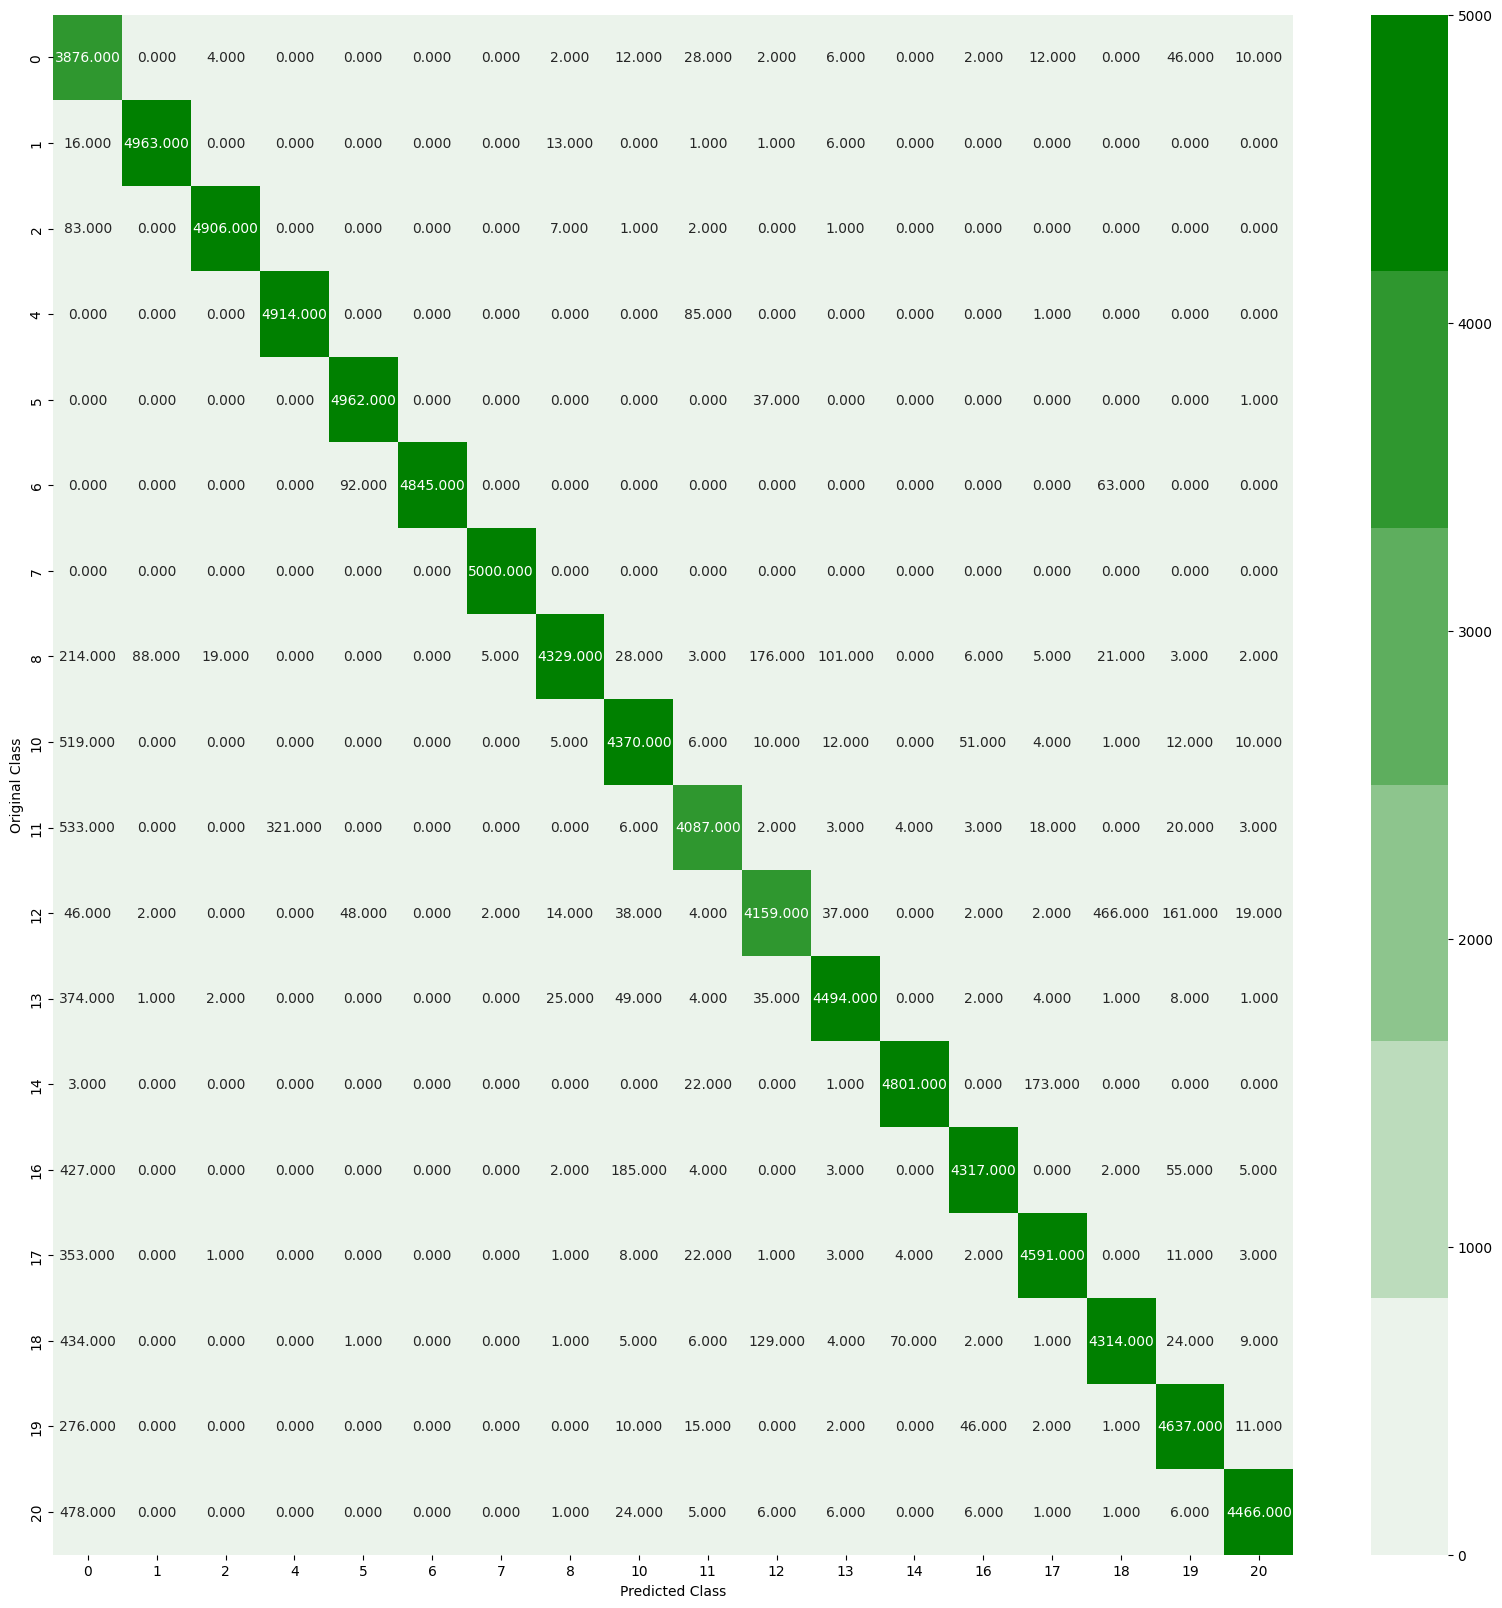

-------------------------------------------------- Precision matrix --------------------------------------------------


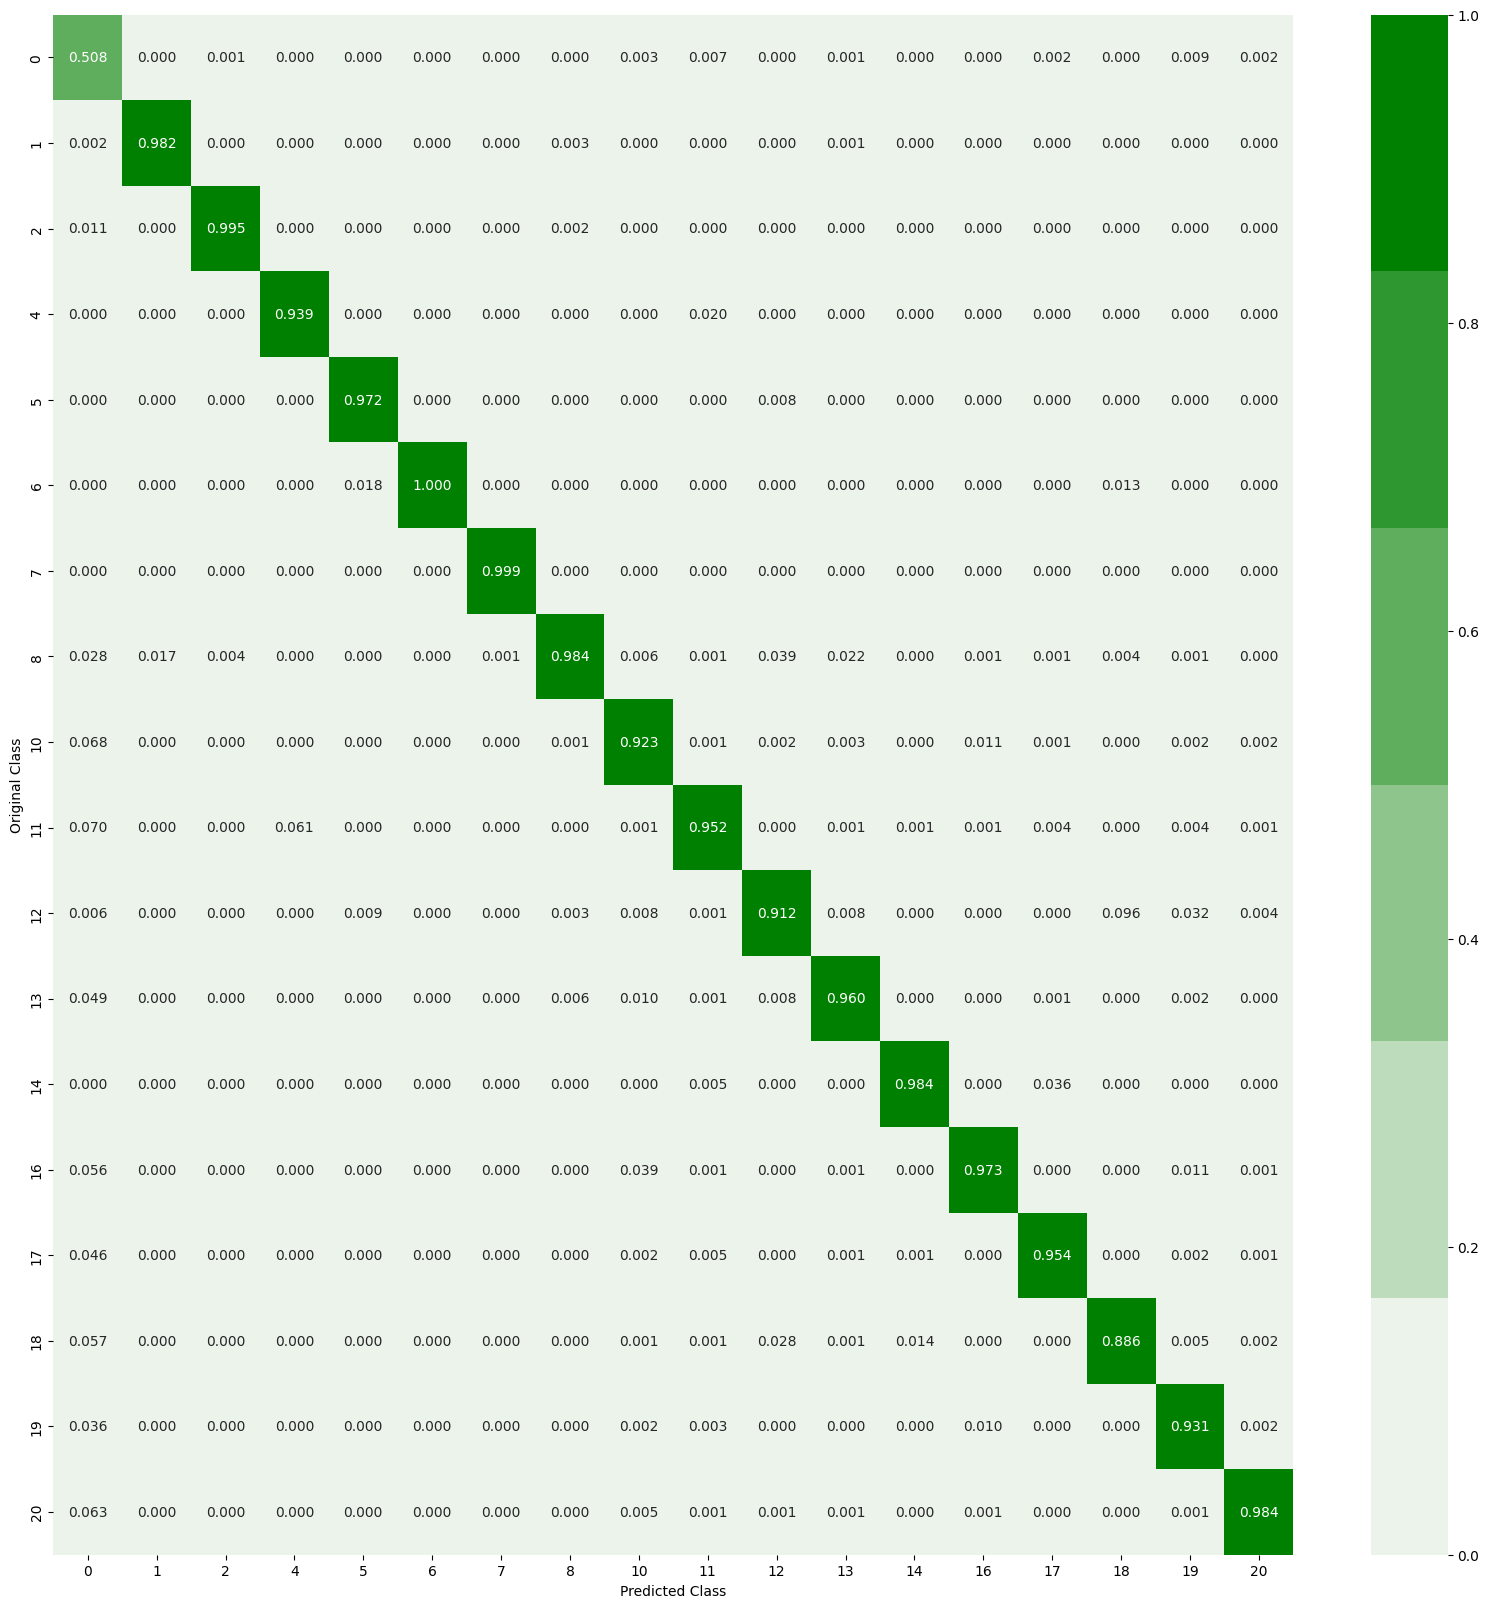

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


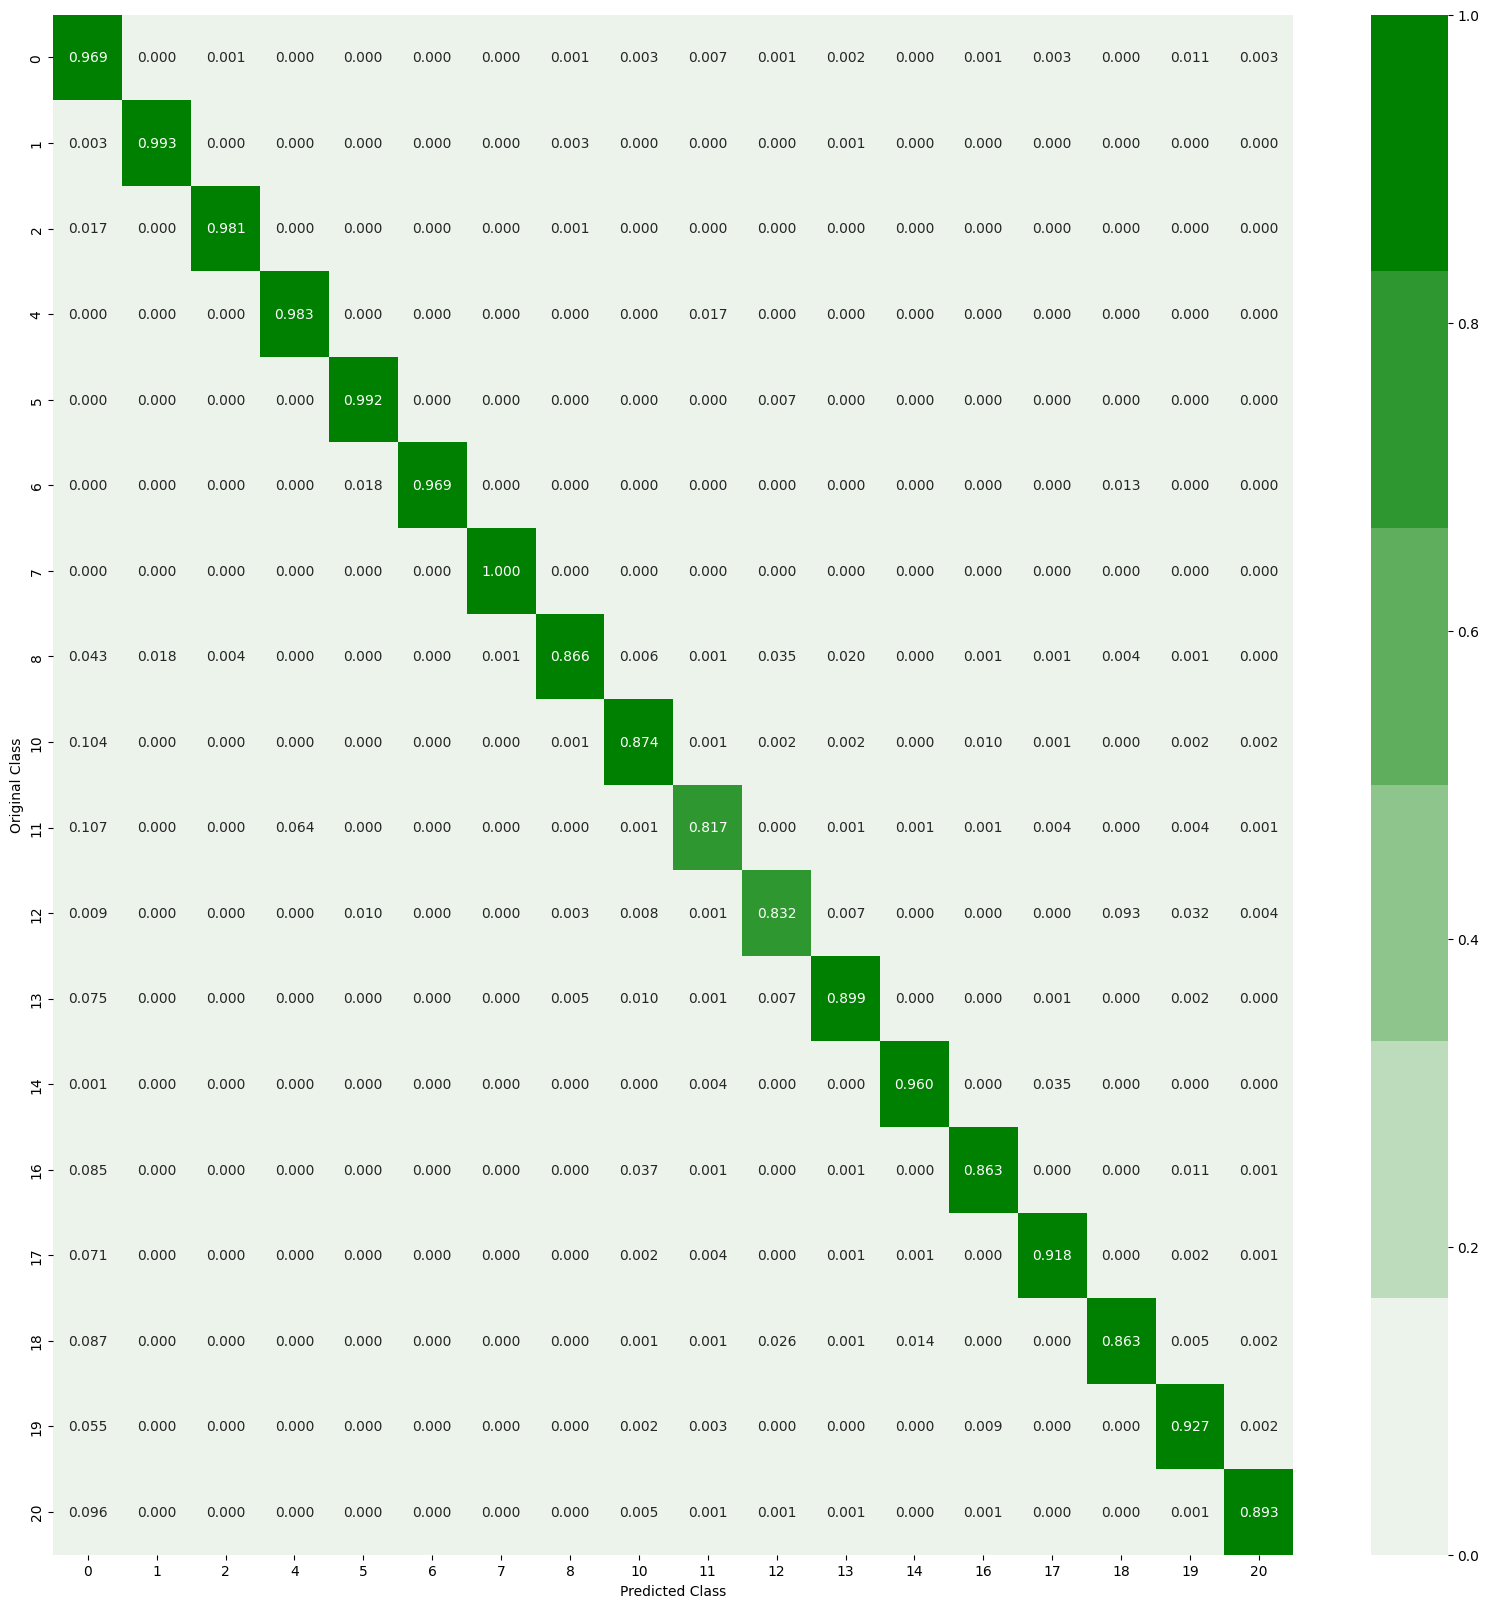

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# Obtener las probabilidades predichas del modelo
predict_y_prob = model.predict(test_norm)

# Convertir las probabilidades predichas en clases
predict_y_classes = np.argmax(predict_y_prob, axis=1)

predict_y_multilabel = np.argmax(predict_y_prob, axis=1)

# Convertir las clases predichas a un formato multilabel-indicator
#predict_y_multilabel = label_binarize(predict_y_classes, classes=np.unique(y_test_encoded))

# Llamar a la función plot_confusion_matrix con las etiquetas verdaderas y las predicciones
plot_confusion_matrix(np.argmax(y_test_encoded.toarray(), axis=1), predict_y_classes)


### Partial Dependence Plot (PDP)

Las PDP son gráficos que nos ayudan a entender cómo una variable específia afecta a las predicciones de nuestro modelo.

    - Para construir una PDP debemos elegir la característica de entrada que será la que queramos analizar.
    - Variamos su valor, es decir mantenemos constantes todas las demás variables y modificamos gradualmente el valor de la variable seleccionada.
    - Calculamos las predicciones, es decir, para cada valor de la variable calculamos las predicciones del modelo.
    - Graficamos estos resultados. Representamos en un gráfico cómo cambian las predicciones a medida que varia la variable

El eje x representa los valores de la variable (característica) seleccionada, y el eje y muestra las predicciones del modelo.

Una vez que tengamos las gráficas dibujadas podremos analizarlas para ver como se comportan. Si la curva es lineal, significa que la relación entre la variable y la predicción es aditiva. Es decir no hay muchas interacciones con otras características. Mientras que si no ocurre esto, podría significar que la característica es dependiente de otras características.

Las partial dependence plot asumen que las variables no están correlacionadas, pero si hay variables correlacionadas los resultados puedes resultar engañosos.

En nuestro caso vamos a observar constantes picos y oscilaciones brutas, esto nos va a indicar que nuestas características tienen interacción entre ellas, además si dos características interactúan de manera no lineal entre ellas podría resultar en este tipo de gráficas.

En un segundo ejemplo eliminaremos las características que estén correlacionadas entre ellas para poder volver a analizarlas y observar de forma más exacta que está sucediendo.

Para poder abordar las PDP de forma matemática debemos presentar algunas definiciones.

    - Modelo de regresión. Un modelo de regresión es un enfoque estadístico usado para modelar y analizar la relación entre unna o más variables independientes (características) y una variablbe dependiente continua. La idea principal de este modelo es oredecir o estimar el valor de la variable dependiente en función de los valores de las variables independientes.
        - En este modelo, podemos expresar la relación entre las variables independientes y la dependiente mediante una función matemática. Esta función se usa para realizar las predicciones sobre la variable dependiente en funcionn de los valores de las variables independientes.

Existen varios tipos de modelos de regresión, cada uno de los cuales usa diferentes funciones matemáticas para modelar la relación entre las varibales. Entre ellos encontramos la regresión lineal, regresión polinómica, regresión logística y refrfesión de árbol de decisiones. 


Ahora supongamos que tenemos un modelo de regresión $f(x)$ que predice una variable de respuesta $Y$ en función de $p$ características de entrada $X=(X_1, X_2, X_3,....)$

El objetivo que se busca a través de las PDP es visualizar como cambia la predicción del modelo $f(x)$ cuando variamos una o varias características de entrada $X_i$, manteniendo el resto de características constantes o promediadas.


La función de la dependencia parcial $PD_i(x_i)$ para una característica $X_i$ se define como 
$$PD_i(x_i)=E_{x_i}[f(x)]$$

In [13]:
import shap

Grafica de 1
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 421us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 417us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 422us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 424us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 425us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/st

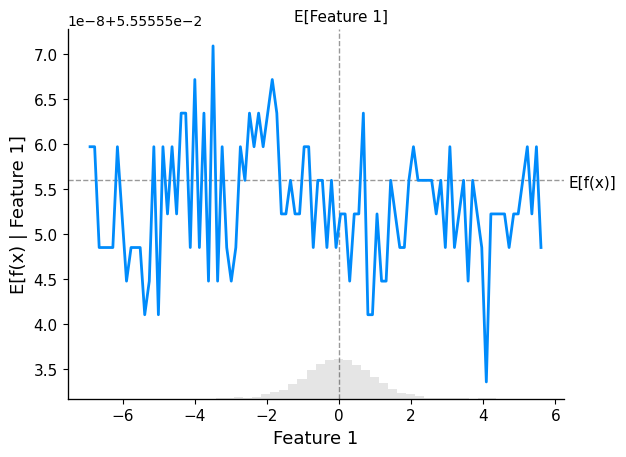

Grafica de 2
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 449us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 470us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 464us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 474us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/st

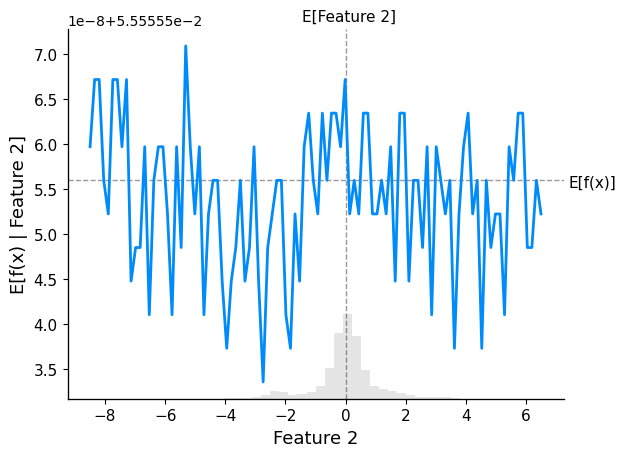

Grafica de 3
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 455us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 452us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 466us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/st

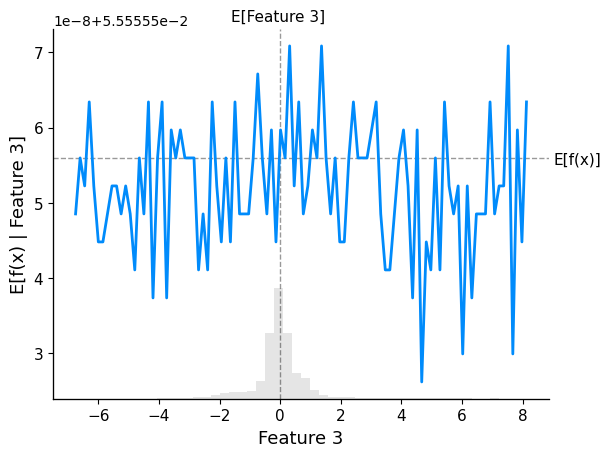

Grafica de 4
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 424us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 425us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/st

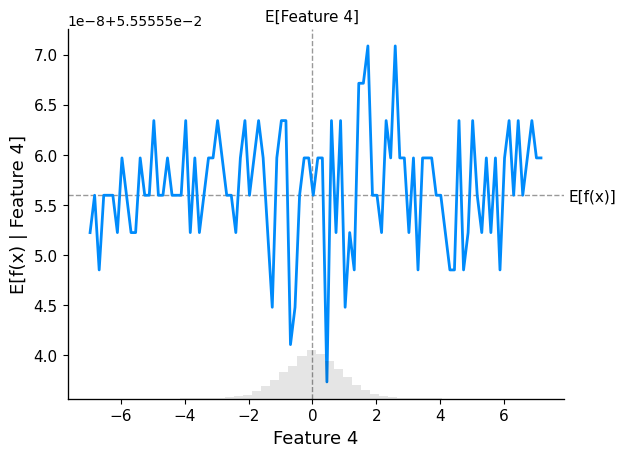

Grafica de 5
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 425us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 425us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 458us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 448us/st

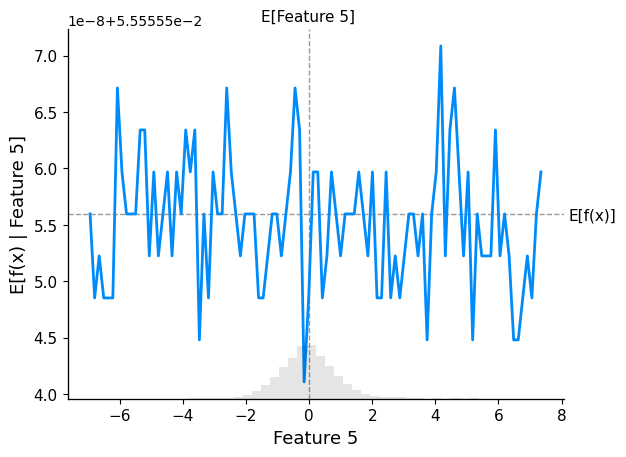

Grafica de 6
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 455us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 462us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 421us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 450us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 424us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 448us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 459us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 470us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 455us/st

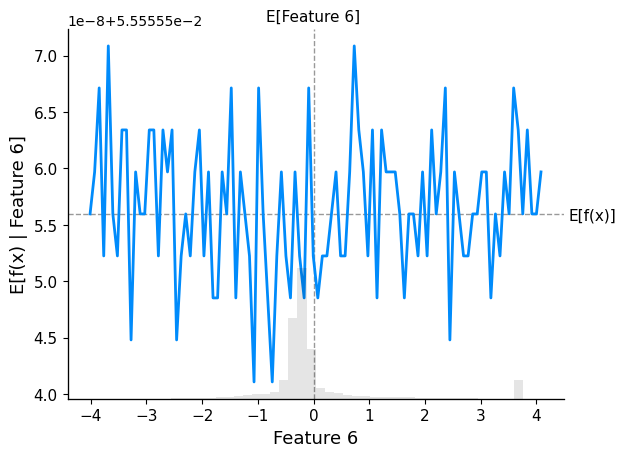

Grafica de 7
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 463us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 450us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 464us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 462us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 448us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/st

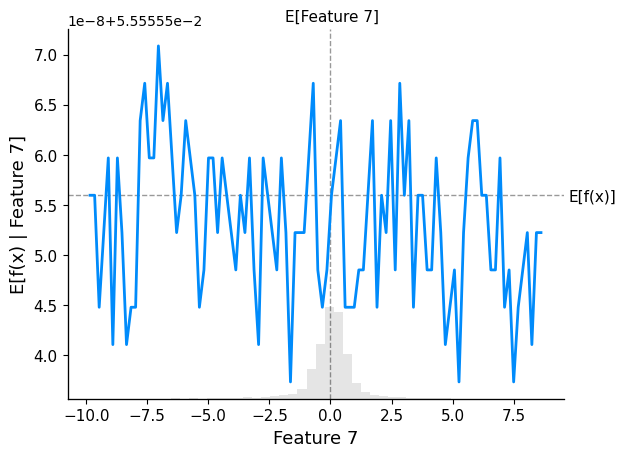

Grafica de 8
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/st

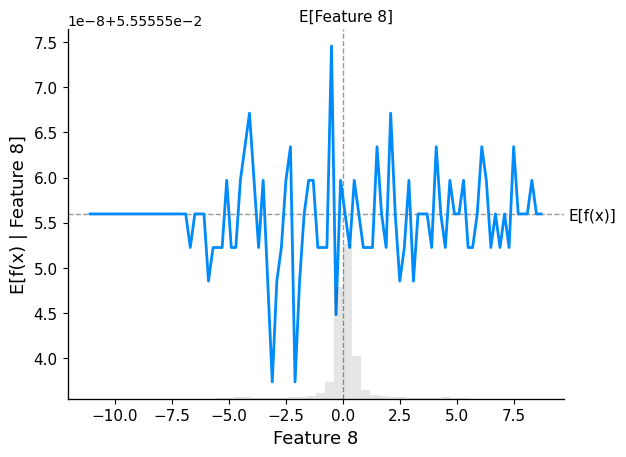

Grafica de 9
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/st

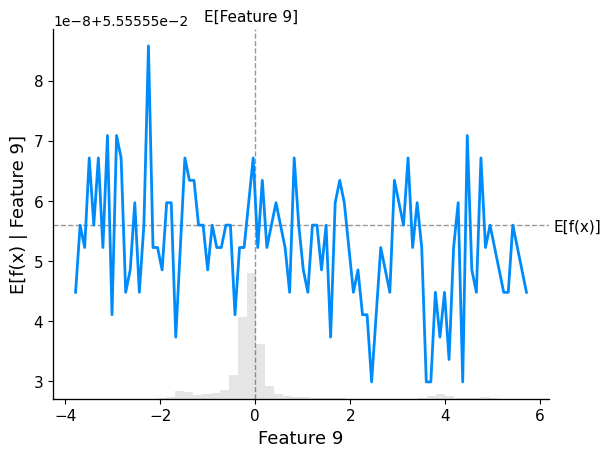

Grafica de 10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 424us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/s

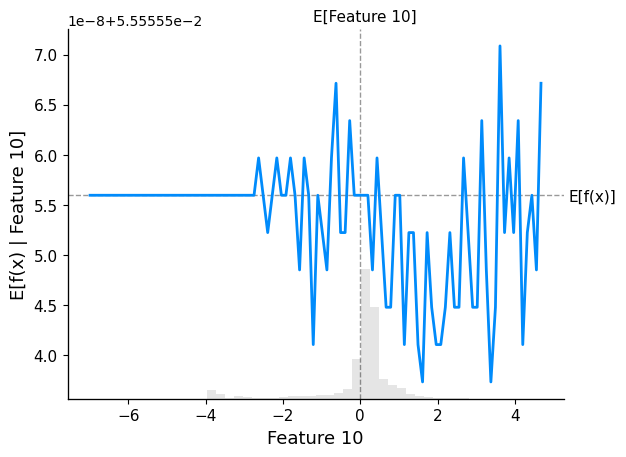

Grafica de 11
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 472us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 450us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 463us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 454us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/s

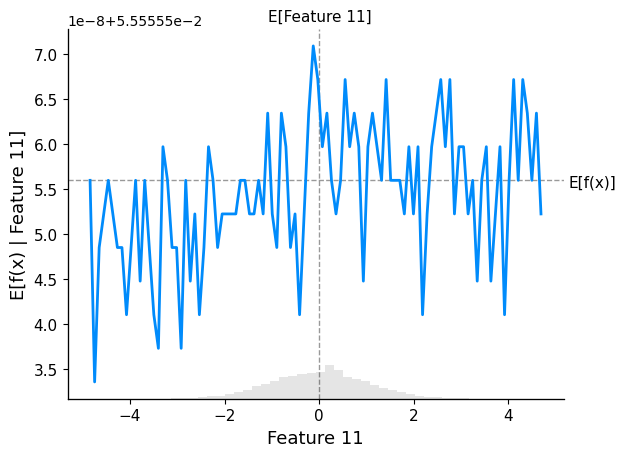

Grafica de 12
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 436us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 452us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 457us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 472us/s

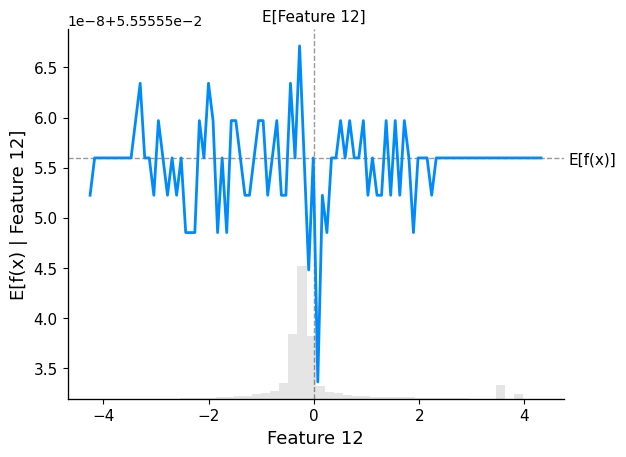

Grafica de 13
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 452us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 449us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 443us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/s

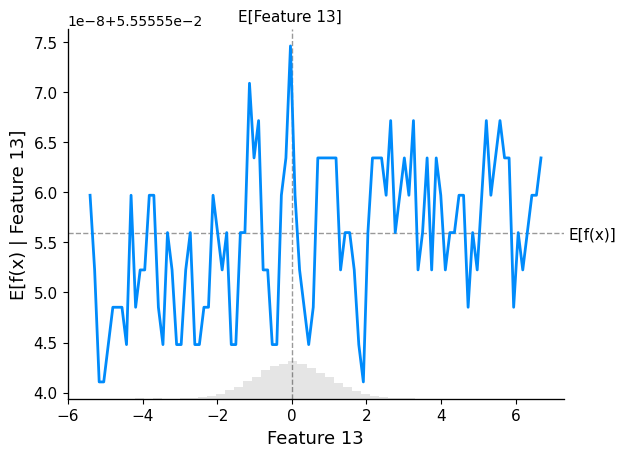

Grafica de 14
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 461us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 466us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 472us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 474us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 469us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 466us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 431us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/s

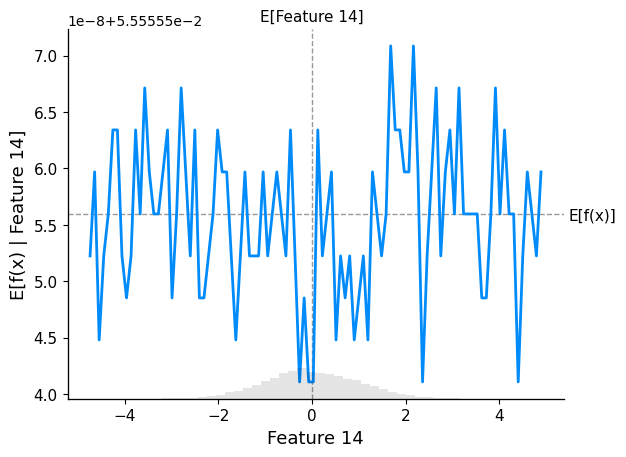

Grafica de 15
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 453us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 429us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 445us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 441us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 440us/s

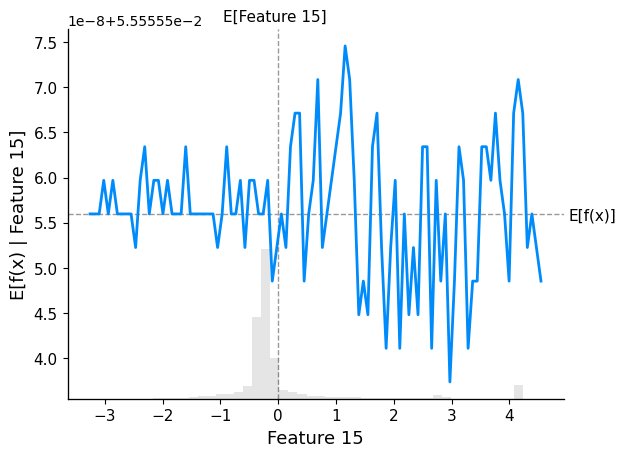

Grafica de 16
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 434us/step


KeyboardInterrupt: 

In [15]:
for i in range(1, 52):
    print('Grafica de', i)
    shap.plots.partial_dependence(
    #    i, lambda x: model.predict(x)[0], train_norm, ice=False,
        i, model.predict, train_norm, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

### ICE PLOT

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(52,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, batch_size=32, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
predictions = model.predict(test_norm)
print("Accuracy:", predictions)


Epoch 1/10


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1713884973.460009  452667 service.cc:145] XLA service 0x7f0da4017db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713884973.460033  452667 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1713884973.460035  452667 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-23 17:09:33.475004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 17:09:33.537107: I externa

 259/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 584us/step - accuracy: 0.2443 - loss: 2.5431

I0000 00:00:1713884974.424440  452667 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 853us/step - accuracy: 0.6618 - loss: 1.1454 - val_accuracy: 0.8584 - val_loss: 0.5446
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 804us/step - accuracy: 0.8710 - loss: 0.4524 - val_accuracy: 0.8958 - val_loss: 0.4483
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 808us/step - accuracy: 0.8977 - loss: 0.3658 - val_accuracy: 0.9107 - val_loss: 0.4643
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 797us/step - accuracy: 0.9197 - loss: 0.3017 - val_accuracy: 0.9224 - val_loss: 0.4603
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 789us/step - accuracy: 0.9269 - loss: 0.2778 - val_accuracy: 0.9260 - val_loss: 0.4879
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 824us/step - accuracy: 0.9303 - loss: 0.2617 - val_accuracy: 0.9281 - val_loss: 0.4922
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 813us/step - accuracy: 0.9327 - loss: 0.2538 - val_accuracy: 0.9326 - val_loss: 0.5072
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 782us/step - accuracy: 0.9342 - loss: 0.24